this is the logistic reg !!!


In [1]:
import pandas as pd
import numpy as np
import string
import nltk
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from scipy.sparse import hstack
from nltk.corpus import stopwords
from nltk import pos_tag, word_tokenize
# from sklearn.exceptions import ConvergenceWarning
# import warnings

# # Suppress specific warnings
# warnings.filterwarnings("ignore", category=ConvergenceWarning)
# warnings.filterwarnings("ignore", category=UserWarning)

# Ensure required NLTK data is downloaded
nltk.download('stopwords')

# Load stopwords
stop_words = set(stopwords.words('english'))

# Function to calculate additional features
def calculate_text_features(text):
    # Word Count
    word_count = len(text.split())
    # Average Word Length
    words = text.split()
    avg_word_length = sum(len(word) for word in words) / word_count if word_count > 0 else 0
    # Punctuation Count
    punctuation_count = sum(1 for char in text if char in string.punctuation)
    # Stopword Count
    stopword_count = sum(1 for word in words if word.lower() in stop_words)
    # Digit Count
    digit_count = sum(1 for char in text if char.isdigit())
    # POS Tagging
    pos_tags = pos_tag(word_tokenize(text))
    noun_count = sum(1 for word, tag in pos_tags if tag.startswith('NN'))
    # Exclamation Count
    exclamation_count = text.count('!')
    # Question Count
    question_count = text.count('?')
    # Title Word Count
    title_word_count = sum(1 for word in words if word.istitle())
    
    return (word_count, avg_word_length, punctuation_count, stopword_count, digit_count, noun_count,
            exclamation_count, question_count, title_word_count)

# Load dataset
df = pd.read_csv('sampled_data.csv', header=None, names=['text', 'label'], delimiter=',', quoting=3)

# Split data into features and labels
X = df['text']
y = df['label']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Convert text data to numerical data using CountVectorizer
vectorizer = CountVectorizer()
X_train_vect = vectorizer.fit_transform(X_train)
X_test_vect = vectorizer.transform(X_test)

# Calculate additional features for training data
X_train_features = np.array([calculate_text_features(text) for text in X_train])
# Calculate additional features for testing data
X_test_features = np.array([calculate_text_features(text) for text in X_test])

# Combine CountVectorizer output with additional features
X_train_combined = hstack([X_train_vect, X_train_features])
X_test_combined = hstack([X_test_vect, X_test_features])

# Hyperparameter tuning using GridSearchCV
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'solver': ['newton-cg', 'lbfgs', 'liblinear']
}
grid = GridSearchCV(LogisticRegression(max_iter=1000), param_grid, cv=5, scoring='accuracy')
grid.fit(X_train_combined, y_train)

print(f"Best Parameters: {grid.best_params_}")
print(f"Best Cross-validation Score: {grid.best_score_}")

# Train a Logistic Regression model with best parameters
model = LogisticRegression(**grid.best_params_, max_iter=1000)
model.fit(X_train_combined, y_train)

# Predict on the test set
y_pred = model.predict(X_test_combined)

# Evaluate the model
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Test the model with new examples
new_examples = [
    "I am so excited about the upcoming vacation!",
    "I feel completely overwhelmed with work right now.",
    "The kids are really making me angry today."
]

# Convert new examples to numerical data using the same vectorizer
new_examples_vect = vectorizer.transform(new_examples)

# Calculate additional features for new examples
new_examples_features = np.array([calculate_text_features(text) for text in new_examples])

# Combine CountVectorizer output with additional features for new examples
new_examples_combined = hstack([new_examples_vect, new_examples_features])

# Predict emotions for the new examples
predictions = model.predict(new_examples_combined)

# Output predictions
for example, prediction in zip(new_examples, predictions):
    print(f"Text: {example}")
    print(f"Predicted Emotion: {prediction}")
    print()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\zohar\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
c:\Users\zohar\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Users\zohar\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    h

Best Parameters: {'C': 100, 'solver': 'liblinear'}
Best Cross-validation Score: 0.7652380952380952
Accuracy: 0.7855555555555556
Classification Report:
              precision    recall  f1-score   support

       anger       0.86      0.74      0.79       162
        fear       0.75      0.74      0.74       151
         joy       0.70      0.74      0.72       148
        love       0.86      0.83      0.84       143
     sadness       0.72      0.72      0.72       141
    surprise       0.84      0.94      0.88       155

    accuracy                           0.79       900
   macro avg       0.79      0.79      0.78       900
weighted avg       0.79      0.79      0.79       900

Text: I am so excited about the upcoming vacation!
Predicted Emotion: joy

Text: I feel completely overwhelmed with work right now.
Predicted Emotion: surprise

Text: The kids are really making me angry today.
Predicted Emotion: anger



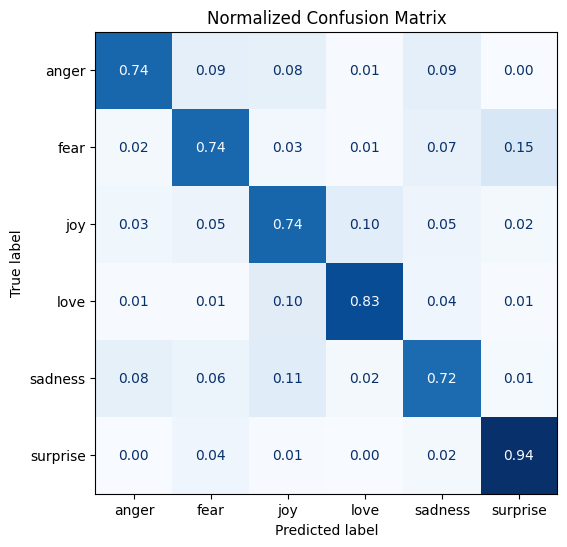

In [3]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def plot_confusion_matrix(y_predicted, y_true, labels):
    cm = confusion_matrix(y_true, y_predicted, normalize='true')
    fig, ax = plt.subplots(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap='Blues', values_format='.2f', ax=ax, colorbar=False)
    plt.title('Normalized Confusion Matrix')
    plt.show()

# Example usage
labels = df['label'].unique()  # Extract unique labels from the DataFrame
plot_confusion_matrix(y_pred, y_test, labels)
